## Introduction

With the surge of digital device and smart phones, billions of photos are collected everyday. For people who cares about the beauty or the feeling of photos, they hope to be instructed when they are taking or modifying photos to enhance aesthetic values. Also, people love to share photos and watch others' photos in social networks (Facebook, Instagram, snapchat, etc) they hope to share and watch the high-quality photos and got mediocre photos filtered out. Therefore, a trained 'aesthetic evaluator' will give them a pre-judgement about the 'beauty' of the photos, help them create, select best photos.

Traditionally, deciding whether a natural image is beautiful always involves rational justification. According to our observation, appealing images usually share some common features such as regular compositions, gorgeous colors, an outstanding theme, or even some hidden features that human beings don’t realize.

To build a brief view about aesthetics, there are three examples photos about the mountain. Although different people may have vary criteria and subjective aesthetic standard, the left two photos have higher aesthetic values than the right one undoubtedly.
<img src="https://www.dropbox.com/s/ygrq2ehg9vc29m9/3img.png?raw=1">


How to find methods which can help us separates brilliant imags from mediocre images which have lower aesthetic values? In our project, we would explore different methods to solve this challenging question by establishing the aesthetic criteria from machine view and build an aesthetic classifier based on supervised learning.

## Project content

In this project, We will collect image dataset first, and then implement 3 feature extraction approaches, color histogram, convolutional neural network(CNN) with triple loss function and VGG pretrained network. All these featurets would be test on SVM classfier and compared with each other in the end.

We will cover the following topics in this project:

- [Data preparation](#Data-preparation)
- [Image Color histogram](#Color-histogram)
- [CNN with Triplet loss function](#CNN-with-Triplet-loss-function)
- [VGG16 pretrained network](#Feature-Extraction-using-VGG16-pretrained-network)
- [Summary](#Summary)

In [1]:
import mimetypes, httplib, time, sys, os
import unittest
import urllib2
import cv2
import os
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## Data preparation

One of the key factors contributing to our understanding of aesthetics of photographs is the dataset
selection. The image quality and the rating system should be able to reflect the aesthetic value of
a photo based on collective expertise.

According to the criteria above, we chose the photos in Photo.net to train and test the algorithm. Photo.net is a great online photo sharing community with over 400,000 active photographers and they’re constantly doing peer-rating for each other’s works. 

To fetch the image data from photo.net, we have parsed the html page of photo.net, collected photos ids and scores information and downloaded image by id. In addition, the size of images in photo.net are different, we have croped and scaled images to have same size.

### Parse photo.net html page

In photo.net http://photo.net/gallery/photocritique/filter, each finding photo request can match as many as 3000 photos and display 12 photos on each page. Therefore, we used loops to send different requests and collected image ids and scores on each page.

<img src="https://www.dropbox.com/s/1nug4v1ftmftatb/photonet.png?raw=1">

In [4]:
def getPage(url):
    
    #Browser Information
    user_agent = 'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)'
    headers = { 'User-Agent' : user_agent }

    request = urllib2.Request(url,headers = headers)

    #Read response and open the url
    response = urllib2.urlopen(request)

    #Get web page HTML code and decode it
    pageCode = response.read().decode('utf-8')

    return pageCode

def parse_page(html,ids,rates):
    soup = BeautifulSoup(html,"html.parser")
    photos = soup.find_all("div", attrs = {'class':'trp_photo'})
    for photo in photos:
        id = photo.find('a')['href'].split('=')[1]
        rate = str(photo.find('div',attrs={'class':'trp-details'}))
        l = rate.find("<strong>Rating:</strong>")
        r = rate.find("<br>",l)
        rate = rate[l:r].split(' ')[-1]
        if(len(rate)<2):
            continue
        if id in ids:
            continue
        ids.append(id)
        rates.append(float(rate))
    return (ids,rates)
    pass

ids = []
rates = []
for page_index in range(0,3000,12):
    for category in ['Travel','Landscape']:
        for period in ['90','365','365-1','365-2','365-3','365-4','365-5','5000']:
            url = "http://photo.net/gallery/photocritique/filter?period="+ period 
            url += "&rank_by=avg&category=" + category + "&start_index=" + str(page_index) 
            url += "&store_prefs_p=1&shown_tab=1&page=Next"
            html = getPage(url)
            [ids,rates] = parse_page(html,ids,rates)
print "number of different image ids obtained: ",len(ids)

number of different image ids obtained:  36692


After crawling the images, we visualize the score distribution to have a brief understanding of data.

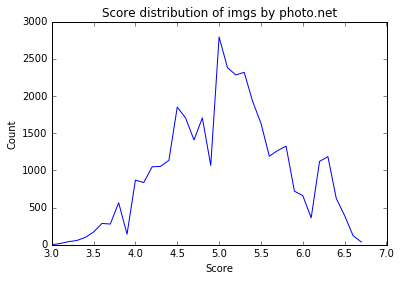

In [6]:
#score distribution visualization
scores = rates
rate = {}
for score in scores:
    score = int(score*10)
    if score not in rate:
        rate[score] = 0
    rate[score] += 1
sd = sorted(rate.items())
X = []
Y = []
for a,b in sd:
    X.append(a/10.0)
    Y.append(b)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score distribution of imgs by photo.net')
plt.plot(X,Y)
plt.savefig('ds_all.png')
plt.show()

### Download image data
To better prepare the datasets used for training and classification, we only collected images from two tails. Specifically, we have ~ 12% negative examples from left side and another ~12% examples from right side. Therefore, we define images with rating score below 4.3 as “negative” image, and images with scores over 6.0 as ”positive” images. 

In [ ]:
# download photos
for i in range(len(ids)):
    id = ids[i]
    score = rates[i]
    if (score<6.0 and score>4.3):
        continue
    url = 'http://gallery.photo.net/photo/'+id+'-md.jpg'
    urllib.urlretrieve(url,"dataset/"+id+"_"+str(score)+".jpeg")

### Canonicalizing Images and Extract labels from file names

We observed different size in different images. Therefore we have cropped images into a square(only keep the center region) and down-sampling them into 96 x 96 pixels image. Also, we parsed the labels from filenames. 

In [2]:
def crop_and_scale_image(im):
    if im.mode is not 'RGB':
        im = im.convert('RGB')
    width,height = im.size
    if width > height:
        diff = width - height
        box = diff/2, 0, width - (diff - diff/2), height
    else:
        diff = height - width
        box = 0, diff/2, width, height - (diff - diff/2)
    im = im.crop(box)
    toSize = 96,96
    im= im.resize(toSize, Image.ANTIALIAS)
    return im

def fnames_to_labels(fnames):
    res = []
    for fname in fnames:
        score = float(fname.split('_')[1].split('.jpeg')[0])
        if score > 5:
            res.append(1)
        else:
            res.append(-1)
    return np.asarray(res)

### Train / Validate / Test splits

Next we have loaded all the 9047 images (4503 pos and 4544 neg) and perform our usual data split. We splited these photos into three categories - 7547 for training, 1000 for validation, and and 500 for testing. 

In [3]:
import random

dname = "dataset/"
im_paths = [dname+fname for fname in os.listdir(dname) if fname.endswith(".jpeg")]
im_paths = np.array(im_paths)
random.shuffle(im_paths)
im_labels = fnames_to_labels(im_paths)

im_paths_pos = im_paths[im_labels>0]
im_paths_neg = im_paths[im_labels<0]
print len(im_paths_pos),len(im_paths_neg)
fnames_te = np.concatenate((im_paths_pos[0:250], im_paths_neg[:250]))
fnames_va = np.concatenate((im_paths_pos[250:750], im_paths_neg[250:750]))
fnames_tr = np.concatenate((im_paths_pos[750:len(im_paths_neg)], im_paths_neg[750:]))
print "Train data size: ",len(fnames_tr)
print "Validation data size: ",len(fnames_va)
print "Test data size: ",len(fnames_te)

4503 4544
Train data size:  7547
Validation data size:  1000
Test data size:  500


## Color histogram

Now we start to extract image features. As aesthetic value is affected by color of image. Color distribution can be represented and visualized using color histogram. Thus, in the first approach, we will explore to use color histogram as features for SVM classifier. The below figure shows the color histogram of an example image.

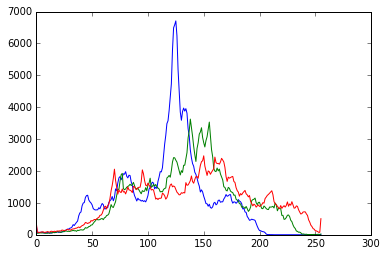

In [10]:
def get_color_histogram(fname):
    ans = []
    img = cv2.imread(fname)
    for channel in range(3):
        try:
            hist = cv2.calcHist([img],[channel],None,[256],[0,256])
            ans.extend([i[0] for i in hist])
        except:
            ans.extend([0 for i in range(256)])
#         plt.plot(hist)
#     plt.show()
    return ans

hist = get_color_histogram('dataset/2572191_6.33.jpeg')

### SVM classifier

After extracting features from color histogram, We applied support vector machine(SVM) to train the classifier. The SVM is known for maximizing margin and can be worked with various kernel, therefore be selected for our binary classification algorithm. We obtained the image pixels and labels from crawled dataset and normalized the color histogram features.

In [7]:
X_tr = [get_color_histogram(fname) for fname in fnames_tr]
X_va = [get_color_histogram(fname) for fname in fnames_va]
X_te = [get_color_histogram(fname) for fname in fnames_te]
y_tr = fnames_to_labels(fnames_tr) 
y_va = fnames_to_labels(fnames_va) 
y_te = fnames_to_labels(fnames_te) 

In [25]:
def normalize(X,maxX,minX):
    X2 = []
    for i in range(len(X)):
        line = []
        for j in range(len(X[i])):
            k = (X[i][j]-minX[j])/(maxX[j]-minX[j])
            line.append(k)
        X2.append(line)
    return np.asarray(X2)
maxX = np.max(X_tr, 0)
minX = np.min(X_tr, 0)
X_tr_norm = normalize(X_tr,maxX,minX)
X_va_norm = normalize(X_va,maxX,minX)
X_te_norm = normalize(X_te,maxX,minX)

We used grid search to find the best SVM parameters in validation dataset, and then use test data with optimzied parameters to get final classifacation accuracy. We also calculated the recalls (*True positive and True negative rates*). True positive is the fraction of the postive examples which are classifed as positive over all positive examples.

In [27]:
from sklearn import svm

def svm_train(X, y, C, gamma):
    rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y)
    return rbf_svc
    pass

def svm_predict(svc, X):
    return svc.predict(X)

C_range = np.logspace(-2, 7, 10)
gamma_range = np.logspace(-8, 1, 10)

best = 0
best_C = 0
best_gamma = 0

# validation
for C in C_range:
    for gamma in gamma_range:
        svc = svm_train(X_tr_norm, y_tr, C, gamma)
        y_p = svm_predict(svc, X_va_norm)
        accuracy = np.mean(y_p==y_va)
        if accuracy > best:
            best = accuracy
            best_C = C
            best_gamma = gamma
        recallT = 0.0
        recallF = 0.0
        for i in range(len(y_va)):
            if (y_p[i]==y_va[i] and y_p[i]>0):
                recallT += 1
            if (y_p[i]==y_va[i] and y_p[i]<0):
                recallF += 1
        print "Validation C: {} gamma:{} accuracy : {} Recall: {},{}".format( C,gamma,accuracy,recallT/(y_va>0).sum(),recallF/(y_va<=0).sum())

After performed validations, we find the best parameters are: C = 0.1 and gama = 0.01, which are used for final training and testing.

In [28]:
#  test
C = 0.1
gamma = 0.01
svc = svm_train(X_tr_norm, y_tr, C, gamma)
y_pt = svm_predict(svc, X_te_norm)
print "Test accuracy: {}".format(np.mean(y_pt==y_te))
recallT = 0.0
recallF = 0.0
for i in range(len(y_te)):
    if (y_pt[i]==y_te[i] and y_pt[i]>0):
        recallT += 1
    if (y_pt[i]==y_te[i] and y_pt[i]<0):
        recallF += 1
print 'Recall: ',recallT/(y_te>0).sum(),recallF/(y_te<=0).sum()

Test accuracy: 0.654
Recall:  0.672 0.636


### Color histogram result analysis

We obtained about 65.4% test accuracy with SVM and RBF kernel. The classification result is not good enough. For aesthetic evaluation, the feature is too abstract and selection is very hard to obtain through traditional computer vision techniques. 

But this experiment of color histogram gives us insights that it's possible to find a way to extract image features to represent the image aesthetic values. We would need to try more intelligent models to address this problem. In recent researches, convolutional neural network (CNN) performs very well in image tasks because of its deep network and learn capacity. In the next part, we will try to apply CNN to approach this challenging topic.

## CNN with Triplet loss function

Inspired from <a href = 'https://devblogs.nvidia.com/parallelforall/understanding-aesthetics-deep-learning/'>Understanding Aesthetics with Deep Learning</a>, a journal form NVIDIA, the challenging problem can be approached by training the Convolution Neural Network of the defined the triplet loss:

Triplet loss =  $max(0, c + Dist( \phi(I_1), \phi(I_2)) - Dist(\phi(I_1), \phi(I_3) )$

The objective of this loss function is let CNN learn the similarity between high-quality images, and learn the difference between high-quality and mediocre images. Therefore, by training the network, we hope to learn a feature representation $\phi(.)$ that the feature distance between two high-quality images is smaller than the feature distance between one high-quality image and one low-quality image. Also, by introducing the margin $c$, we can train the network such that the distance between $\phi(I_1)$ and $\phi(I_3)$ is greater by c than the distance between $\phi(I_1)$ and $\phi(I_2)$.

It is noticeable we are not going to learn the classifier by the triplet loss function and deep network, we are learning features representation method $\phi(.)$. Once we learned $\phi(.)$, we will use SVM to train the classifier using the feature representation of images.

<img src="https://www.dropbox.com/s/flm2ng5hvfykek5/triLoss.jpg?raw=1", height = 800, width = 600>


### Data Processing
The image dataset, we have split them into 5652 images in training dataset, 1000 images in validation dataset, and 500 images in test dataset. The training dataset have around 2:1 regarding positive images and negative images and validation/test have 1:1 positive images and negative images. 

### Design Architecture
We have chosen using tensorflow to implement the Convolutional Neural Network and train feature representation method $\phi(.)$. The CNN Net architecture was reference and simplified from the reference paper[1], page 3273. Specifically, we have implemented the network with following parameters.
<img src="https://www.dropbox.com/s/2h2n33eigsqhsh1/parameterCNN.jpg?raw=1", height = 300, width = 300>

The output of this network is a feature vector with dimension 1024 x 1. The vector is used to calculate the triplet loss and used in Gradient Descent. Also, after the network got trained, this layer is the feature representation of the original image.

For training classifier, we have used SVM classifier from sklearn.

### Implementation with tensorflow

S1: import necessary packages, specify the dataset location and destination file for logs

In [37]:
import tensorflow as tf 
import numpy as np      
from PIL import Image   
import random           
import time             
from sklearn import svm 
import logging          

dataset = './dataset4'
logging.basicConfig(filename='cnnlog017.log',level=logging.DEBUG)

S2: read all image infomation from the csv file, and divide images into positive images and negative images

In [38]:
# Reading train set                                             
posImg_ids_Tr = []                                              
posImg_scores_Tr = []                                           
negImg_ids_Tr = []                                              
negImg_scores_Tr = []                                           
with open( dataset + '/ratingsInfo/train.csv', 'r') as f:       
    f.readline()                                                
    for line in f.readlines():                                  
        img_id,img_score,img_label = line.strip().split(',')    
        if float(img_label) > 0:                                
            posImg_ids_Tr.append(img_id)                        
            posImg_scores_Tr.append(img_score)                  
        else:                                                   
            negImg_ids_Tr.append(img_id)                        
            negImg_scores_Tr.append(img_score)                  
print "Train Set Positive Images: ", len(posImg_ids_Tr)
print "Train Set Negative Images: ",len(negImg_ids_Tr)                                                   
# Reading validation set                                        
posImg_ids_Va = []                                              
posImg_scores_Va = []                                           
negImg_ids_Va = []                                              
negImg_scores_Va = []                                           
with open(dataset + '/ratingsInfo/validation.csv', 'r') as f:   
    f.readline()                                                
    for line in f.readlines():                                  
        img_id,img_score,img_label = line.strip().split(',')    
        if float(img_label) > 0:                                
            posImg_ids_Va.append(img_id)                        
            posImg_scores_Va.append(img_score)                  
        else:                                                   
            negImg_ids_Va.append(img_id)                        
            negImg_scores_Va.append(img_score)                  
            
print "Validation Set Positive Images: ",len(posImg_ids_Va)
print "Validation Set Negative Images: ", len(negImg_ids_Va)

# Reading the test set                                          
posImg_ids_Te = []                                              
negImg_ids_Te = []                                              
posImg_scores_Te = []                                           
negImg_scores_Te = []                                           
with open(dataset + '/ratingsInfo/test.csv', 'r') as f:         
    f.readline()                                                
    for line in f.readlines():                                  
        img_id,img_score,img_label = line.strip().split(',')    
        if float(img_label) > 0:                                
            posImg_ids_Te.append(img_id)                        
            posImg_scores_Te.append(img_score)                  
        else:                                                   
            negImg_ids_Te.append(img_id)                        
            negImg_scores_Te.append(img_score)    

print "Test Set Positive Images: ", len(posImg_ids_Te)
print "Test Set Negative Images: ", len(negImg_ids_Te)




Train Set Positive Images:  3753
Train Set Negative Images:  1899
Validation Set Positive Images:  500
Validation Set Negative Images:  500
Test Set Positive Images:  250
Test Set Negative Images:  250


S3: Read and store positive images, negative images separately into np.arrays. Note Anchor images are also from positive images dataset. You can think Anchor images as $I_1$ images above. There are more positive examples because half of them are functioned as anchor images.

In [39]:
def readImgs_intoNpArray(path, image_id_list, image_score_list):
    filenames = []
    for img_id, img_score in zip(image_id_list, image_score_list):
        name = path + img_id + '_' + img_score + '.jpeg'
        filenames.append(name)
    imgs = np.array([np.array(Image.open(fname)) for fname in filenames])
    return imgs


path_Tr = dataset + '/train/'                                              
pos_img_Tr = readImgs_intoNpArray(path_Tr, posImg_ids_Tr, posImg_scores_Tr)
neg_img_Tr = readImgs_intoNpArray(path_Tr, negImg_ids_Tr, negImg_scores_Tr)
anchor_img_Tr = readImgs_intoNpArray(path_Tr, posImg_ids_Tr, posImg_scores_Tr)
pos_list_Tr = range(len(pos_img_Tr))                                       
neg_list_Tr = range(len(neg_img_Tr))                                       
                                                                           
path_Va = dataset + '/validation/'                                         
pos_img_Va = readImgs_intoNpArray(path_Va, posImg_ids_Va, posImg_scores_Va)
neg_img_Va = readImgs_intoNpArray(path_Va, negImg_ids_Va, negImg_scores_Va)
                                                                           
path_Te = dataset + '/test/'                                               
pos_img_Te = readImgs_intoNpArray(path_Te, posImg_ids_Te, posImg_scores_Te)
neg_img_Te = readImgs_intoNpArray(path_Te, negImg_ids_Te, negImg_scores_Te)

print "Anchor (Positive) Training Images size ", anchor_img_Tr.shape
print "Positive Training Images size ", pos_img_Tr.shape
print "Negative Training Images size ", neg_img_Tr.shape

print "Positive Validation Images size ", pos_img_Va.shape
print "Negative Training Images size ", neg_img_Va.shape

print "Positive Test Images size ", pos_img_Te.shape
print "Negative Test Images size ", neg_img_Te.shape


Anchor (Positive) Training Images size  (3753, 96, 96, 3)
Positive Training Images size  (3753, 96, 96, 3)
Negative Training Images size  (1899, 96, 96, 3)
Positive Validation Images size  (500, 96, 96, 3)
Negative Training Images size  (500, 96, 96, 3)
Positive Test Images size  (250, 96, 96, 3)
Negative Test Images size  (250, 96, 96, 3)



S4: Implement the Convolutional Neural Network with TensorFlow and train classifier using SVM.


There are lots of implementation details and some most important of them are:

- For symmetry breaking, kernel weights are initialized with a small amount of noise.
- when training SVM classifier, we use a linear kernel with optimized regularization parameter from stochastic validation.
- The training set is used to train both CNN for feature representations and used to train the SVM classifier.  However, when training SVM, we used only half positive examples so that training set has the same amount of examples in both classes.
- The batched Adam Stochastic Optimization was used to iteratively reduce the loss function. The batch size is selected from our stochastic validation (you will see soon).
- For better train the loss function, we observed that learning rate in Adam Stochastic Optimization should decay as the iteration increases. we select the decay parameters to make learning rate following this trend.
<img src="https://www.dropbox.com/s/p9l0b4s03r6a4x3/learnrate.jpg?raw=1", height = 300, width = 300>
- The results **are not** printed into stdout. All the important results are saved in *.log file in current directory.
- You will note the same network was going through three times in each iteration (the first for loop in RunAndTest function). This is because of the batched anchor images, batched positive images, and batched negative images need to go through the network and get their outputs respectively. The triplet loss is calculated after all of them are obtained.




In [40]:
def weight_variable(shape):                                       
  initial = tf.truncated_normal(shape, stddev=0.1)                
  return tf.Variable(initial)                                     
                                                                  
def bias_variable(shape):                                         
  initial = tf.constant(0.1, shape=shape)                         
  return tf.Variable(initial)                                     
                                                                  
def max_pool_2x2(x):                                              
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],                    
                        strides=[1, 2, 2, 1], padding='SAME')     
def avg_pool_2x2(x):                                              
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],                    
                        strides=[1, 2, 2, 1], padding='SAME')  

def predict_from_features(X_train, y, X_test, SVMReg = 1):                                              
                                                                                                        
    # C = 1 # SVM regularization parameter                                                              
                                                                                                        
    lin_svc = svm.SVC(kernel='linear', C=SVMReg, verbose=True, max_iter= 1000000).fit(X_train, y)       
                                                                                                        
    Te_res = lin_svc.predict(X_test)                                                                    
    Tr_res = lin_svc.predict(X_train)                                                                   
    return Te_res, Tr_res                                                                               
                                                                                                        
# featuresRes1: features positive                                                                       
# featuresRes2: features negative                                                                       
def doSVM(featuresRes_pos_Tr,featuresRes_neg_Tr, featuresRes_pos_Te, featuresRes_neg_Te, SVMReg = 1):   
    TrainExamplesNum = len(featuresRes_pos_Tr) / 2;                                                     
    posTrainX =featuresRes_pos_Tr[:TrainExamplesNum,:]                                                  
    posTrainy = np.ones( len(posTrainX) )                                                               
                                                                                                        
    posTestX =featuresRes_pos_Te                                                                        
    posTesty = np.ones( len(posTestX) )                                                                 
                                                                                                                                                                       
    negTrainX = featuresRes_neg_Tr                                                                      
    negTrainy = -1 * np.ones( len(negTrainX) )                                                          
    negTestX = featuresRes_neg_Te                                                                       
    negTesty = -1 * np.ones( len(negTestX) )                                                            
                                                                                                        
    trainX =  np.concatenate((posTrainX, negTrainX), axis=0)                                            
    trainX = trainX.astype(float)                                                                       
    trainy =  np.concatenate((posTrainy, negTrainy))                                                    
                                                                                                        
    testX =  np.concatenate((posTestX, negTestX), axis=0)                                               
    testX = testX.astype(float)                                                                         
    testy =  np.concatenate((posTesty, negTesty))                                                       
                                                                                                        
    start = time.time()                                                                                 
    y_p, y_p_tr = predict_from_features(trainX, trainy, testX, SVMReg)                                  
    # np.savetxt("predict.csv", y_p, delimiter=',')                                                     
    # y_p_tr = predict_from_features(trainX, trainy, testX, max_iter)                                   
    end = time.time()                                                                                   
    recallT = 0.0                                                                                       
    recallF = 0.0                                                                                       
    try:                                                                                                
        for i in range(len(testy)):                                                                     
            if (y_p[i] == testy[i] and y_p[i]>0):                                                       
                recallT += 1                                                                            
            if (y_p[i] == testy[i] and y_p[i]<0):                                                       
                recallF += 1                                                                            
        recall = [recallT/(testy>0).sum(),recallF/(testy<0).sum()]                                      
    except:                                                                                             
        recall = []                                                                                     
                                                                                                        
    train_acc = np.mean(y_p_tr == trainy)                                                                                                                                                                    
    return np.mean(y_p == testy), end-start, recall, y_p, train_acc                                     

def RunAndTest( pos_img, neg_img, anchor_img, pos_list, neg_list, pos_img_Te, ne_img_Te, pos_img_Va, neg_img_Va, margin=1000, keepProb = 0.2, learningRate=1e-4, iter_time=200, batch_size = 16, SVMReg = 1):
                                                                                                                                                                                                             
    sess = tf.InteractiveSession()                                                                                                                                                                           
    width = 96                                                                                                                                                                                               
    height = 96                                                                                                                                                                                              
    channel = 3                                                                                                                                                                                              
                                                                                                                                                                                                             
    anchor_input = tf.placeholder(tf.float32, [None, width, height, channel])                                                                                                                                
    positive_input = tf.placeholder(tf.float32, [None, width, height, channel])                                                                                                                              
    negative_input = tf.placeholder(tf.float32, [None, width, height, channel])                                                                                                                              
    global_step = tf.Variable(0, trainable=False)                                                                                                                                                            
                                                                                                                                                                                                             
                                                                                                                                                                                                             
    # Initialize variables                                                                                                                                                                                   
    W_conv1 = weight_variable([5, 5, 3, 32])                                                                                                                                                                 
    b_conv1 = bias_variable([32])                                                                                                                                                                            
                                                                                                                                                                                                             
    W_conv2 = weight_variable([5, 5, 32, 64])                                                                                                                                                                
    b_conv2 = weight_variable([64])                                                                                                                                                                          
                                                                                                                                                                                                             
    W_conv3 = weight_variable([3, 3, 64, 128])                                                                                                                                                               
    b_conv3 = weight_variable([128])                                                                                                                                                                         
                                                                                                                                                                                                             
    W_conv4 = weight_variable([3, 3, 128, 256])                                                                                                                                                              
    b_conv4 = weight_variable([256])                                                                                                                                                                         
                                                                                                                                                                                                             
    W_conv5 = weight_variable([3, 3, 256, 256])                                                                                                                                                              
    b_conv5 = weight_variable([256])                                                                                                                                                                         
                                                                                                                                                                                                             
    W_fcl = weight_variable([3 * 3 * 256, 1024])                                                                                                                                                             
    b_fcl = weight_variable([1024])                                                                                                                                                                          
    fcl = []                                                                                                                                                                                                 
    flat_list = []                                                                                                                                                                                           
    for train_img in [anchor_input, positive_input, negative_input]:                                                                                                                                         
        # CNN1                                                                                                                                                                                               
        h_conv1 = tf.nn.relu(tf.nn.conv2d(train_img, W_conv1, [1,1,1,1], 'SAME') + b_conv1)                                                                                                                  
        h_pool1 = max_pool_2x2(h_conv1)                                                                                                                                                                      
                                                                                                                                                                                                             
        # CNN2                                                                                                                                                                                               
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, [1,1,1,1], 'SAME') + b_conv2)                                                                                                                    
        h_pool2 = max_pool_2x2(h_conv2)                                                                                                                                                                      
                                                                                                                                                                                                             
        # CNN3                                                                                                                                                                                               
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, [1,1,1,1], 'SAME') + b_conv3)                                                                                                                    
        h_pool3 = max_pool_2x2(h_conv3)                                                                                                                                                                      
                                                                                                                                                                                                             
        # CNN4                                                                                                                                                                                               
        h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool3, W_conv4, [1,1,1,1], 'SAME') + b_conv4)                                                                                                                    
        h_pool4 = max_pool_2x2(h_conv4)                                                                                                                                                                      
                                                                                                                                                                                                             
        # CNN5                                                                                                                                                                                               
        h_conv5 = tf.nn.relu(tf.nn.conv2d(h_pool4, W_conv5, [1,1,1,1], 'SAME') + b_conv5)                                                                                                                    
        h_pool5 = avg_pool_2x2(h_conv5)                                                                                                                                                                      
                                                                                                                                                                                                             
        # flatten the CNN                                                                                                                                                                                    
        h_pool5_flat = tf.reshape(h_pool5, [-1, 3 * 3 * 256])                                                                                                                                                
                                                                                                                                                                                                             
        h_fcl = tf.nn.relu(tf.matmul(h_pool5_flat, W_fcl) + b_fcl)                                                                                                                                           
        h_fcl = tf.nn.dropout(h_fcl, keep_prob=keepProb)                                                                                                                                                     
                                                                                                                                                                                                             
        fcl.append(h_fcl)                                                                                                                                                                                    
        flat_list.append(h_pool5_flat)                                                                                                                                                                       
                                                                                                                                                                                                             
    anchor_image = fcl[0]                                                                                                                                                                                    
    positive_image = fcl[1]                                                                                                                                                                                  
    negative_image = fcl[2]                                                                                                                                                                                  
    d_pos = tf.reduce_sum(tf.square(anchor_image - positive_image), 1)                                                                                                                                       
    d_neg = tf.reduce_sum(tf.square(anchor_image - negative_image), 1)                                                                                                                                       
                                                                                                                                                                                                             
    triplet_loss_val = tf.maximum(0., margin + d_pos - d_neg)                                                                                                                                                
    triplet_loss = tf.reduce_mean(triplet_loss_val)                                                                                                                                                          
                                                                                                                                                                                                             
    decay_lr = tf.train.exponential_decay(learningRate, global_step, 100, 0.975, staircase=True)                                                                                                             
    train_step = tf.train.AdamOptimizer(decay_lr).minimize(triplet_loss, global_step=global_step)                                                                                                            
                                                                                                                                                                                                             
    sess.run(tf.global_variables_initializer())                                                                                                                                                              
    print "start AdamOptimizer..."                                                                                                                                                                                     
                                                                                                                                                                                                             
    # Iteration begins                                                                                                                                                                                       
    for i in range(iter_time):                                                                                                                                                                               
        # Select train batch                                                                                                                                                                                 
        batch_anchor = anchor_img[random.sample(pos_list, batch_size)]                                                                                                                                       
        batch_pos = pos_img[random.sample(pos_list, batch_size)]                                                                                                                                             
        batch_neg = neg_img[random.sample(neg_list, batch_size)]                                                                                                                                             
                                                                                                                                                                                                             
        # Train a step                                                                                                                                                                                       
        train_step.run(feed_dict={anchor_input: batch_anchor, positive_input: batch_pos, negative_input: batch_neg})                                                                                         
                                                                                                                                                                                                             
        lossVal = triplet_loss.eval( feed_dict={anchor_input: batch_anchor, positive_input: batch_pos, negative_input: batch_neg} )                                                                          
        print "lossVal: ", lossVal                                                                                                                                                                           
                                                                                                                                                                                                             
        if i is not 1 and i % 5000 is 1:                                                                                                                                                                     
            print "iteration at: " + str(i)                                                                                                                                                                  
            print "Start Evaluate the feature..."                                                                                                                                                            
                                                                                                                                                                                                             
            # Train data features                                                                                                                                                                            
            # positive Train Features                                                                                                                                                                        
            featuresRes_pos_Tr = fcl[1].eval( feed_dict={anchor_input: pos_img, positive_input: pos_img, negative_input: neg_img })                                                                          
            # negative Train Features                                                                                                                                                                        
            featuresRes_neg_Tr = fcl[2].eval( feed_dict={anchor_input: pos_img, positive_input: pos_img, negative_input: neg_img})                                                                           
                                                                                                                                                                                                             
            # positive validation features                                                                                                                                                                   
            featuresRes_pos_Va = fcl[1].eval( feed_dict={anchor_input: pos_img_Va, positive_input: pos_img_Va, negative_input: neg_img_Va} )                                                                 
            # negative validation features                                                                                                                                                                   
            featuresRes_neg_Va = fcl[2].eval( feed_dict={anchor_input: pos_img_Va, positive_input: pos_img_Va, negative_input: neg_img_Va})                                                                  
                                                                                                                                                                                                             
            print "start SVM..."                                                                                                                                                                             
            Testacc, SVMtime, Recall, y_p, train_acc = doSVM(featuresRes_pos_Tr, featuresRes_neg_Tr, featuresRes_pos_Va, featuresRes_neg_Va, SVMReg)                                                         
            logging.info("At iteration: " + str(i) + " loss value: " + str(lossVal) + " recall: " + str(Recall) + " Train Accuracy: " + str(train_acc) + ", Test Accuracy: " + str(Testacc) )                

The skeleton code was referred from an MNIST digit classification example from tensorflow website: https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html. 

#### Run the stochastic validation to select good hyperparameters and test the algorithm.

One of greatest challenges in deep networks are always selecting parameters. We did not use grid search to find the best parameters since there are too many parameters to tune (in our case, there are 5 parameters and 576 combinations), and each of them takes hours to train. Alternatively, We used the stochastic method to tune the parameters and record the parameters and results in the .log file.

In [ ]:
margins  = [1, 10, 100, 1000]
batchSizes = [16 ,32, 64]
dropOutProbs = [0.01, 0.2, 0.3, 0.5]
learnRates = [5e-4, 2e-4, 1e-4, 5e-5]
SVMRegularizations = [0.1,1,10]
iterationTime = 10001
for i in range(100):
    margin = random.choice(margins)
    batch_size = random.choice(batchSizes)
    dropOutProb = random.choice(dropOutProbs)
    learnRate = random.choice(learnRates)
    SVMreg = random.choice(SVMRegularizations)
    logging.info( "time: " + str(i) + "margin: " + str(margin) + " batchSize: " + str(batch_size) + " dropOut: " + str(dropOutProb) + " learnRate: " + str(learnRate) + " SVM REG: "  + str(SVMreg) )
    testErr = RunAndTest(pos_img_Tr, neg_img_Tr, anchor_img_Tr, pos_list_Tr, neg_list_Tr, pos_img_Te, neg_img_Te, pos_img_Va, neg_img_Va, margin=margin, keepProb=dropOutProb, learningRate=learnRate, iter_time= iterationTime, batch_size = batch_size, SVMReg = SVMreg)

In our stochastic validation, we repeatedly to randomly select one parameter combination from hyperplane and record the parameters resulting in best validation accuracy. We have opened 1 x c4.8xlarge instance (36 cores) and 3 x c4.4xlarge (16 cores) in AWS and test 100 parameter combinations in total, this takes about 18 hours to finish. We found that the best parameters are:

margin: 10 , batchSize: 16, dropOut: 0.2, learnRate: 5e-05, SVM REG: 0.1

We used the selected parameters on the test dataset and achieved 66.8% test accuracy, with True positive 69.6% and True negative 64%.

#### CNN with Triplet loss function result analysis

The result from CNN network can achieve 66.8% accuracy, it demonstrates the effectiveness of the feature selection by using triplet loss to train the convolutional network, but it is still not as good as expected, through we have paid lots of efforts on tuning the parameters and optimizing the network structure. We have the summaries that the reasons might be:

- Structure of network: 
The convolution network is not deep and wide enough to extract best features. In VGG16, there are 13 convolutional  layers and 3 fully connected layers. Therefore, VGG is able to extract very good features with its strong network and tuned parameters. With the network only have 5 convolutional layers and 1 fully connected layer, the best features are not easily extracted.

- Parameters tuning: 
Selecting the right parameters actually takes lots of more time and resources. We do have the implemented the stochastic validation to find the good parameters, but it is not enough. The choice set of each parameter are come from our experiments and experience, in reality we need to try much more different parameters. Also, we need to do more runs and validations to find the best parametres.

- Network Optimization: 
There are also lots of things to tune in the network. e.g. In convolutional layers, the size of kernel, the pooling methods, the activation function, the number of channels etc. In whole network, the number of convolutional or fully connected layers, the number of neurons in fully connected layers, etc.

To achieve the best performance there are lots of work to do, unfortunately, at this time we are not able to do all of them due to time and resources limit. We implemented the simplified network to indicates the effectiveness of this approach, and we do think the capability of this approaches once it got well trained and tuned.



##  Feature Extraction using VGG16 pretrained network

The limitation of training the CNN from scratch makes us think of using pre-trained models for some popular pre-defined nets. We choose VGG16 to get the pre-trained model since it has been well defined and trained with very deep network and it generalizes well to other datasets. The VGG pre-trained weights are available at its <a href = "https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view">source website</a>. We have used the pre-trained model to extract features for images. Note We use the output from the flatten layer as extracted features for images.

The codes are referred from <a href = "https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3"> VGG16 github page </a> and some changed has been made to fit for our original image size and desired feature output. 



In [9]:
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)
    
    new_model = Sequential()
    new_model.add(ZeroPadding2D((1,1),input_shape=(3,96,96)))
    new_model.add(Convolution2D(64, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(64, 3, 3, activation='relu'))
    new_model.add(MaxPooling2D((2,2), strides=(2,2)))

    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(128, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(128, 3, 3, activation='relu'))
    new_model.add(MaxPooling2D((2,2), strides=(2,2)))

    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(256, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(256, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(256, 3, 3, activation='relu'))
    new_model.add(MaxPooling2D((2,2), strides=(2,2)))

    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(MaxPooling2D((2,2), strides=(2,2)))

    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(ZeroPadding2D((1,1)))
    new_model.add(Convolution2D(512, 3, 3, activation='relu'))
    new_model.add(MaxPooling2D((2,2), strides=(2,2)))

    new_model.add(Flatten())
    
    weights = model.get_weights()
    new_model.set_weights(weights)
    
    return new_model
    
trained_vgg = VGG_16("vgg16_weights.h5")

The VGG codes are referred from <a href="https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3"> VGG Keras Github page </a>. 
After load the pre-trained weights into VGG16 network, we can now transform original images (3x 96 x 96) into feature vectors (1 x 4608) from flatten layer.

In [35]:
def get_Vgg16features(fnames, vgg):
    result = []
    for fname in fnames:
        im = Image.open(fname)
        im = crop_and_scale_image(im)
        if im.mode is not 'RGB':
            im = im.convert('RGB')
        npim = np.asarray(im)
        vgg_input = np.rollaxis(npim, 2)
        result.append(vgg_input)
        
    result_np = np.asarray(result)
    print result_np.shape
    return vgg.predict(result_np), fnames_to_labels(fnames)

X_tr, y_tr = get_Vgg16features(fnames_tr, trained_vgg)
X_va, y_va = get_Vgg16features(fnames_va, trained_vgg)
X_te, y_te = get_Vgg16features(fnames_te, trained_vgg)

As the dimension of vgg features is 4608, which is larger than the size of dataset, it is easy to overfit when we train the models since we only have ~2800 training examples. Therefore, we applied PCA to extract principle components as new features but has lower dimension, and train the SVM classifier with new features.To find the best parameters, we did validations and use the optimized parameters to work on testset.

In [ ]:
from sklearn.decomposition import PCA
best = 0
best_C = 0
best_gamma = 0
best_pca_n = 0

# validation
for pca_n in [1024,2048,3072,4096]:
    pca = PCA(n_components=pca_n)
    X_tr_pca = pca.fit_transform(X_tr)
    X_va_pca = pca.transform(X_va)
    for C in C_range:
        for gamma in gamma_range:
            svc = svm_train(X_tr_pca, y_tr, C, gamma)
            y_p = svm_predict(svc, X_va_pca)
            accuracy = np.mean(y_p==y_va)
            if accuracy > best:
                best = accuracy
                best_C = C
                best_gamma = gamma
                best_pca_n = pca_n
            recallT = 0.0
            recallF = 0.0
            for i in range(len(y_va)):
                if (y_p[i]==y_va[i] and y_p[i]>0):
                    recallT += 1
                if (y_p[i]==y_va[i] and y_p[i]<0):
                    recallF += 1
            print "Validation PCA_N: {} C: {} gamma:{} accuracy: {} Recall: {},{}".format(pca_n,C,gamma,accuracy,recallT/(y_va>0).sum(),recallF/(y_va<=0).sum())

We got the optimized parameters: SVM regularization parameter C = 1, RBF kernel radius gamma = 1e-6, and use PCA to extract 3072 principle components.

In [ ]:
# test
pca_n = 3072
C = 1
gamma = 1e-6
pca = PCA(n_components=pca_n)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)
svc = svm_train(X_tr_pca, y_tr, C, gamma)
y_pt = svm_predict(svc, X_te_pca)
print "Test accuracy: {}".format(np.mean(y_pt==y_te))
recallT = 0.0
recallF = 0.0
for i in range(len(y_te)):
    if (y_pt[i]==y_te[i] and y_pt[i]>0):
        recallT += 1
    if (y_pt[i]==y_te[i] and y_pt[i]<0):
        recallF += 1
print 'Recall: ',recallT/(y_te>0).sum(),recallF/(y_te<=0).sum()

The test accuracy is: 84% with True positive 83.2% and True negative 84.8%.

#### VGG newtwork result analysis

Since VGG has deep network and generalize well to other datasets[3]. The VGG16 pre-trained model did improve the model accuracy to 84%. Because VGG network is not explicitly learning the aesthetic features, There are still some images are misclassified. An improvement can be done is that use pre-trained weights as initial values and further train the network by optimizing the triplet loss, therefore aesthetic features can be better extracted. Also, the aesthetic classification is not an easy problem. We can see from the False positive and False negative samples that some misclassified images are even hard to be classified correctly by people:

<img src="https://www.dropbox.com/s/pb826ivkhhzunte/false.png?raw=1">

## Summary 

In this project, we have come up different approaches and implemented all pipelines to answer the very challenge problem: evaluate the aesthetic values for photos. 36,692 original photos with scores were crawled from photo.net and   ~9,000 of them with very high or very low scores were selected to form training, validation and test sets. We experimented with different models to train the machine to be an 'aesthetic evaluator'. As the baseline, color histogram was built to extract features for SVM classifier and achieve 65.4% test accuracy. To improve the accuracy, we used the defined triplet loss to train a simplified Convolutional network and learned the aesthetic features. The accuracy of SVM classifier trained on these features has achieved 66.8% test accuracy, not a significant improvement because resources limitations but has great improvement space. Finally, we have used the pre-trained very deep VGG16 network to obtain features and learned the SVM classifier, the test accuracy of 84% has been achieved.

### Limitations and Further Consideration

We are addressing a very challenging problem. Accurately evaluate the aesthetic value of an image is very difficult, even with the human. Some photos are too abstract to be recognized and appreciated. Also, the aesthetic value is a bit of subjective, although people has common sense about beauty, but possibilities exist that different people have different perspectives and experiences. Therefore, the goal of this project does not achieve a perfect classifier, but try to give people a rough value of the photos for reference. Also, we would like to try to approach this challenging problem and reinforce our understandings on data processing and deep learning fields. 

There are lots of improvements can be considered. We have witnessed a very deep network like VGG is powerfully working on images, and the triplet loss function is very good 'learning criteria'. Hence, I believe an algorithm combines them will yield to better accuracy. We can either use pre-train weights as initial variables and further train the VGGNet by triplet loss, or a CNN has a similar structure as VGG16Net can be built and trained from scratch. After appropriate parameter tuning and apply some tricks we think the accuracy could be significantly improved. Also, there is improvement can be done in the dataset. We have only used ~9,000 high contrast images for training the network and this is typically not enough for a deep network. Getting more training images with high contrast will improve the accuracy.

### Reference
1. Understanding Aesthetics with Deep Learning. NVIDIA Website, Available:  https://devblogs.nvidia.com/parallelforall/understanding-aesthetics-deep-learning/
2. Deep MNIST for Experts on tensorflow. Available: https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html
3. VGG16 Github Keras. Available: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
4. Data source we used to crawl: http://photo.net/
5. Simultaneous Feature Learning and Hash Coding with Deep Neural Networks, Hanjiang Lai† , Yan Pan, Ye Liu , and Shuicheng Yan, CVPR 2015.
6. VGG homepage, Available: http://www.robots.ox.ac.uk/~vgg/research/very_deep/
7. Part of work are referred from CMU practical data science homework, Available: http://www.datasciencecourse.org/